https://www.sciencedirect.com/science/article/pii/S1474667017382836

Using neural network and FOPDT model to estimate plant.
Then using FOPDT parameters tune the PID

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import tensorflow as tf
from tensorflow.python.framework import ops

In [2]:
d_t = 0.01
d_t_decimal = str(d_t)[::-1].find('.')
steps = 3000

class PID:
    def __init__(self, Kp=0, Ki=0, Kd=0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.I_max = 5
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0
        
    def update(self, e, t):
        delta_time = t - self.t_prev
        delta_error = e - self.e_prev
        
        self.P = e
        
        self.I += e * delta_time

        if (self.I < -self.I_max):
            self.I = -self.I_max
        elif (self.I > self.I_max):
            self.I = self.I_max

        if delta_time > 0:
            self.D = delta_error / delta_time
        else:
            self.D = 0

        self.t_prev = t
        self.e_prev = e

        self.u = self.Kp * self.P + self.Ki * self.I + self.Kd * self.D
        
    def get_u(self):
        return self.u
    
    def update_gains(self, K, tau, T):
        #658.PDF
        a1=1.086
        b1=-0.869
        a2=0.740
        b2=-0.130
        a3=0.348
        b3=0.914
        
        weight = 1.0
        try:
            delta_Kp = a1/K*(T/tau)**b1
        except ZeroDivisionError as e:
            delta_Kp = 0   
        try:
            delta_Ki = tau/(a2+b2*(T/tau))
        except ZeroDivisionError as e:
            delta_Ki = 0
        try:
            delta_Kd = a3*tau*(T/tau)**b3
        except ZeroDivisionError as e:
            delta_Kd = 0
        
        self.Kp = self.Kp * (1-weight) + delta_Kp * weight
        self.Ki = self.Ki * (1-weight) + delta_Ki * weight
        self.Kd = self.Kd * (1-weight) + delta_Kd * weight
  

In [3]:
class FOPDT_Model:
    def __init__(self, K, tau, T):
        self.K = K
        self.tau = tau
        self.T = T
        
        self.y_0 = 0
        self.t1 = 0
        self.t2 = 0
        self.u = np.empty
        self.T_prev = 0
    
        #Records for visualization
        self.K_gr = []
        self.tau_gr = []
        self.T_gr = []
        self.K_r = []
        self.tau_r = []
        self.T_r = []
        
    def check_nan(self, K, tau, T):
        if np.isnan(K):
            K = 0
#             print("K is nan")
        if np.isnan(tau):
            tau = 0
#             print("tau is nan")
        if np.isnan(T):
            T = 0
        return K, tau, T
        
    def model_process(self, y, t, K, tau, T):
        u_delay = self.get_u_prev(t, T)
        dydt = (-y + K * u_delay)/tau
        return dydt
    
    def model(self, K, tau, T):
        #K: gain
        #tau: time constant
        #T: delay
        K, tau, T = self.check_nan(K, tau, T)
        self.K = K
        self.tau = tau
        self.T = T
        
        self.K_r.append(K)
        self.tau_r.append(tau)
        self.T_r.append(T)
        
        ts = [self.t1, self.t2]
        return odeint(self.model_process, self.y_0, ts, args=(K, tau, T))[1].astype(np.float32)
    
    def d_model(self, K, tau, T):
        K, tau, T = self.check_nan(K, tau, T)

        T1 = self.T_prev
        T2 = T
        delta_t = self.t2 - self.t1
        delta_T = T2 - T1
        u_T1 = self.get_u_prev(self.t2, T1)
        u_T2 = self.get_u_prev(self.t2, T2)
        
        dydK = delta_t * u_T2/(tau + delta_t)
        dydK = dydK.astype(np.float32)
        
        dydtau = (-delta_t*K*u_T2 + delta_t*self.y_0)/(tau + delta_t)**2
        dydtau = dydtau.astype(np.float32)
        if delta_T == 0:
            dydT = np.float32(0)
        else:
            dydT = delta_t * K * (u_T2 - u_T1)/(delta_T)
            dydT = dydT.astype(np.float32)
        
        self.K_gr.append(dydK)
        self.tau_gr.append(dydtau)
        self.T_gr.append(dydT)
        return dydK, dydtau, dydT
    
    def set_state(self, y_0, t1, t2, u, T_prev):
        self.y_0 = y_0
        self.t1 = t1
        self.t2 = t2
        self.u = u
        self.T_prev = T_prev
        
    def get_u_prev(self, t, T):
        t_delay = round(t-T, d_t_decimal)
        if (t_delay<= 0) or (t_delay<0.0):
            return self.u[0]
        else:
            step_t = int(t_delay/d_t)-1
            if step_t >= steps:
                return self.u[-1]
            else: 
                return self.u[step_t]  
            
    def get_K(self):
        return self.K
    
    def get_tau(self):
        return self.tau
    
    def get_T(self):
        return self.T

def plant_process(y, t, u):
    K = 0.01
    tau = 1.0
    T = 0.2
    
    t_delay = round(t-T, d_t_decimal)
    if (t_delay<= 0) or (t_delay<0.0):
        u_delay = u[0]
    else:
        step_t = int(t_delay/d_t)-1
        if step_t >= steps:
            u_delay = u[-1]
        else: 
            u_delay = u[step_t]  
        
    dydt = (-y + K*u_delay)/tau
    return dydt

def plant(y_0, t1, t2, u):
    ts = [t1, t2]
    return odeint(plant_process, y_0, ts, args=(u,))[1]


In [8]:
interval = 500
r_steps = steps//interval

r_sq = np.zeros(steps)
up = 0

for i in range(r_steps):
    if i < r_steps-1:
        r_sq[i * interval:(i+1)*interval] = up
    else:
        r_sq[i * interval:] = up
    if up:
        up = 0.0
    else:
        up = 1.0

t = np.linspace(0, d_t*steps, steps)
r_sin = np.sin(t)

### Plant control with neural network

In [8]:
hidden_layer_size = 8



# initial values
K = 0.01 #gain
tau = 1.0 #time constant
T = 0.2 #delay
T_prev = 0.2

fopdt = FOPDT_Model(K, tau, T)

np_model_32 = np.vectorize(fopdt.model)
np_d_model_32 = np.vectorize(fopdt.d_model)

def tf_d_model(K, tau, T,name=None):
    with tf.name_scope(name, "d_model", [K, tau, T]) as name:
        y = tf.py_func(np_d_model_32,
                        [K, tau, T],
                        (tf.float32, tf.float32, tf.float32),
                        name=name,
                        stateful=False)
        return y

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):

    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))

    tf.RegisterGradient(rnd_name)(grad)  # see _MySquareGrad for grad example
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def modelgrad(op, grad):
    K, tau, T = op.inputs
    
    dydK, dydtau, dydT = tf_d_model(K, tau, T)
#     gradient = tf.concat([], 0)
    return grad * dydK, grad * dydtau, grad * dydT


def tf_model(K, tau, T, name=None):

    with tf.name_scope(name, "model", [K, tau, T]) as name:
        y = py_func(np_model_32,
                        [K, tau, T],
                        [tf.float32],
                        name=name,
                        grad=modelgrad)  # <-- here's the call to the gradient
        return y[0]
    
graph = tf.Graph()
with graph.as_default():
    
    # Placeholder will be fed data at run time with a training minibatch

    tf_u = tf.placeholder(tf.float32,shape=())
    tf_y_plant = tf.placeholder(tf.float32,shape=())
    tf_learning_rate = tf.placeholder(tf.float32, shape=())
    
    
    # Input (1) -> Hidden layer (8)
    # Truncated normal randomly initialize weights using a truncated normal distr
    w1 = tf.Variable(tf.truncated_normal([1, hidden_layer_size]))
    b1 = tf.Variable(tf.ones([hidden_layer_size]))
    
    # Hidden layer (8) -> Output (3)
    w2 = tf.Variable(tf.truncated_normal([hidden_layer_size, 3]))
    b2 = tf.Variable(tf.ones([3]))

    # Forward prop
    z2 = tf.matmul(tf.reshape(tf_u, (1, 1)), w1) + b1
    a2 = tf.nn.relu(z2)
    params = tf.matmul(a2, w2) + b2
    K, tau, T = tf.split(params, 3, 1)
    
    # Params should be positive
    K = tf.math.abs(K)
    tau = tf.math.abs(tau)
    T = tf.math.abs(T)

    y_model = tf_model(K, tau, T)

    
#     # Loss = y of plant - y of model
    loss = tf.losses.mean_squared_error(tf_y_plant, y_model)

    
    optimizer = tf.train.AdamOptimizer(tf_learning_rate).minimize(loss)

    

0.0, 

/Users/james/envs/slw/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


nan, nan, nan, nan, 

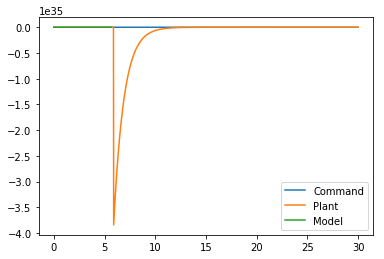

In [9]:
y_0 = 0
y = np.zeros(steps)
y_m = np.zeros(steps)
u = np.zeros(steps)

learning_rate = 0.1


pid = PID(439, 1.4, 0.08)

r = r_sq

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for i in range(len(t))[1:]:  
        
        e = r[i] - y[i-1]
        t_prev = t[i-1]
        t_cur = t[i]
        pid.update(e, t_cur)
        u[i] = pid.get_u()
        y[i] = plant(y_0, t_prev, t_cur, u)

        fopdt.set_state(y_0, t_prev, t_cur, u, T_prev)
       
        feed_dict = {tf_u:u[i], tf_y_plant:y[i], tf_learning_rate:learning_rate}

        _, l, y_m[i] = session.run([optimizer, loss, y_model], feed_dict=feed_dict)
        if i % 500 == 0:
            print(str(l) + ', ', end='')

        T_prev = fopdt.get_T()
        pid.update_gains(fopdt.get_K(), fopdt.get_tau(), fopdt.get_T())

        y_0 = y[i]

plt.plot(t, r)
plt.plot(t, y)
plt.plot(t, y_m)
plt.legend(('Command', 'Plant', 'Model', 'Control'))
plt.show()

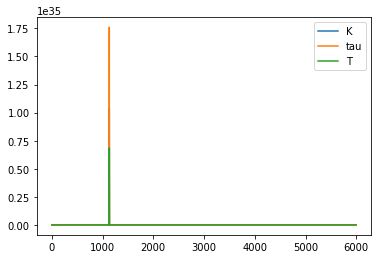

In [10]:
plt.plot(fopdt.K_r)
plt.plot(fopdt.tau_r)
plt.plot(fopdt.T_r)
plt.legend(('K', 'tau', 'T'))

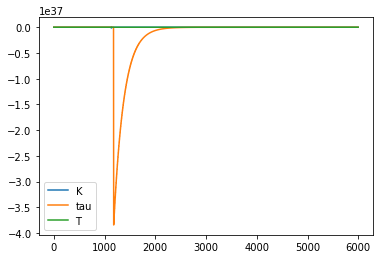

In [11]:
plt.plot(fopdt.K_gr)
plt.plot(fopdt.tau_gr)
plt.plot(fopdt.T_gr)
plt.legend(('K', 'tau', 'T'))

In [12]:
print(fopdt.get_K(), fopdt.get_tau(), fopdt.get_T())

0 0 0


In [6]:
def run_test(r):
    y_m_0 = 0
    y_m = np.zeros(steps)
    y_grad_m = np.zeros(steps)
    u = np.zeros(steps)

    K = 0.05 #gain
    tau = 2.0 #time constant
    T = 0.1 #delay
    T_prev = 0

    pid = PID()
    pid.update_gains(K, tau, T)

    fopdt = FOPDT_Model(K, tau, T)

    for i in range(len(t))[1:]:  
        e = r[i] - y_m[i-1]
        t_prev = t[i-1]
        t_cur = t[i]


        pid.update(e, t_cur)
        u[i] = pid.get_u()
        
        fopdt.set_state(y_m_0, t_prev, t_cur, u, T_prev)
        y_m[i] = fopdt.model(K, tau, T)
        y_grad_m[i] = fopdt.d_model(K, tau, T)[2]

        y_m_0 = y_m[i]

    plt.plot(t, r)
    plt.plot(t, y_m, color='green')
    plt.plot(t, y_grad_m)
    plt.legend(('Command', 'Model', 'Grad'))
    plt.show()

### Tracking for FOPDT model on sinusoidal input using ZN tuning method

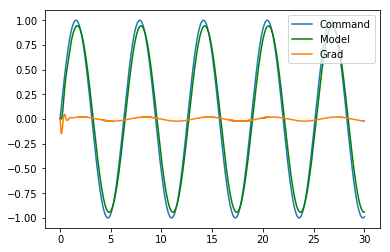

In [14]:
run_test(r_sin)

### Tracking for FOPDT model on sinusoidal input using ZN tuning method

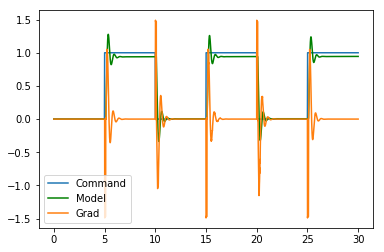

In [9]:
run_test(r_sq)